# Analyze Region 6 - Iceland

This notebook analyzes the largest glaciers, ice caps, and ice fields in Region 6 - Iceland.

This region was deemed as needing a glacier complex analysis (ice caps and icefields), so note that the abbreviation "ic" stands for ice catchment aka glacier complex.

In [1]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "6"
region_name = "Iceland"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
primeclass = 4 # TBD This was not already set in GLIMS so this is my guess at the classification

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 5
region_index_2 = 6

# Ice cap/icefield epsg code used for calculating area
ic_epsg = '3057'

# This variable sets a value to determine whether the differences between the GLIMS and RGI glacier have been checked.
# When first starting a new notebook set handled to 0
# Once the differences have been checked and handled, set to 1 to pass the check 
# in the Compare Glaciers from GLIMS and RGI section towards the middele of this notebook.
handled = 1

# * * * * * * * * Show Region Outline * * * * * * * *

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

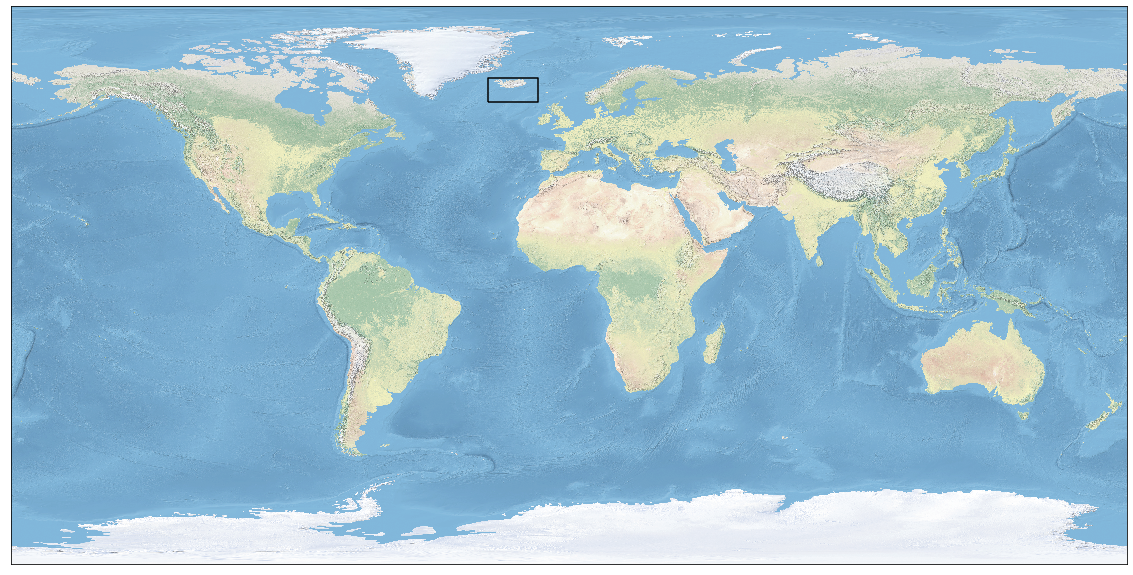

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

,minx,miny,maxx,maxy
5,-26.0,59.0,-10.0,67.0


# * * * * * * * * Glacier Analysis * * * * * * * *

## Open GLIMS 3 Largest Glaciers Data

In [5]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [8]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [10]:
glims_glaciers_df

,region_no,glac_id,area,db_area,width,length,primeclass,min_elev,mean_elev,max_elev,src_date,glac_name,geometry
0,6,G343222E64409N,0.0,8091.670,0.0,0.0,3.0,0.0,0.0,0.0,1999-01-01T00:00:00,Vatnajokull,"(POLYGON Z ((-15.37719 64.66761 0, -15.3766 64..."
1,6,G339764E64629N,0.0,920.587,0.0,0.0,3.0,0.0,0.0,0.0,2000-08-20T00:00:00,Langjokull,"POLYGON Z ((-20.67335 64.596 0, -20.67194 64.5..."
2,6,G341164E64838N,0.0,889.534,0.0,0.0,3.0,0.0,0.0,0.0,1999-08-01T00:00:00,Hofsjokull,"POLYGON Z ((-19.18387 64.75879999999999 0, -19..."
3,6,G340925E63656N,0.0,596.616,0.0,0.0,3.0,0.0,0.0,0.0,1999-08-01T00:00:00,Myrdalsjokull,"(POLYGON Z ((-18.83835 63.67381 0, -18.83813 6..."
4,6,G337738E66173N,0.0,145.933,0.0,0.0,3.0,0.0,0.0,0.0,2004-08-16T00:00:00,Drangajokull,"POLYGON Z ((-22.42765 66.19665000000001 0, -22..."


## Open RGI 3 Largest Glaciers Data

In [10]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [11]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

In [12]:
rgi_glaciers_df

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-06.00475,G342858E64298N,20009999,-9999999,-17.1417,64.2977,6,1,1561.218,111,...,201,61535,0,0,1,0,3,0,Skeidararjoekull,POLYGON ((-16.88670427699998 64.49112664700004...
1,RGI60-06.00377,G343733E64587N,20009999,-9999999,-16.2675,64.5867,6,1,1428.724,649,...,19,57016,0,0,1,0,3,1,Bruarjoekull,POLYGON ((-16.14149351299994 64.78313950300003...
2,RGI60-06.00483,G343523E64267N,20009999,-9999999,-16.4767,64.2666,6,1,1067.745,97,...,135,53427,0,0,1,0,3,9,Breidamerkurjoekull,POLYGON ((-16.87625468499994 64.49406953800008...
3,RGI60-06.00477,G342946E64674N,20009999,-9999999,-17.0539,64.6745,6,1,1060.639,752,...,26,45502,0,0,1,0,3,1,Dyngjujoekull,POLYGON ((-16.74238713099993 64.82769281100008...
4,RGI60-06.00416,G342298E64282N,20009999,-9999999,-17.7021,64.2820,6,1,757.308,607,...,220,51856,0,0,1,0,3,9,Sidujoekull/Skaftarjoekull,POLYGON ((-17.32864904799993 64.39716217000006...


## Plot GLIMS Glaciers

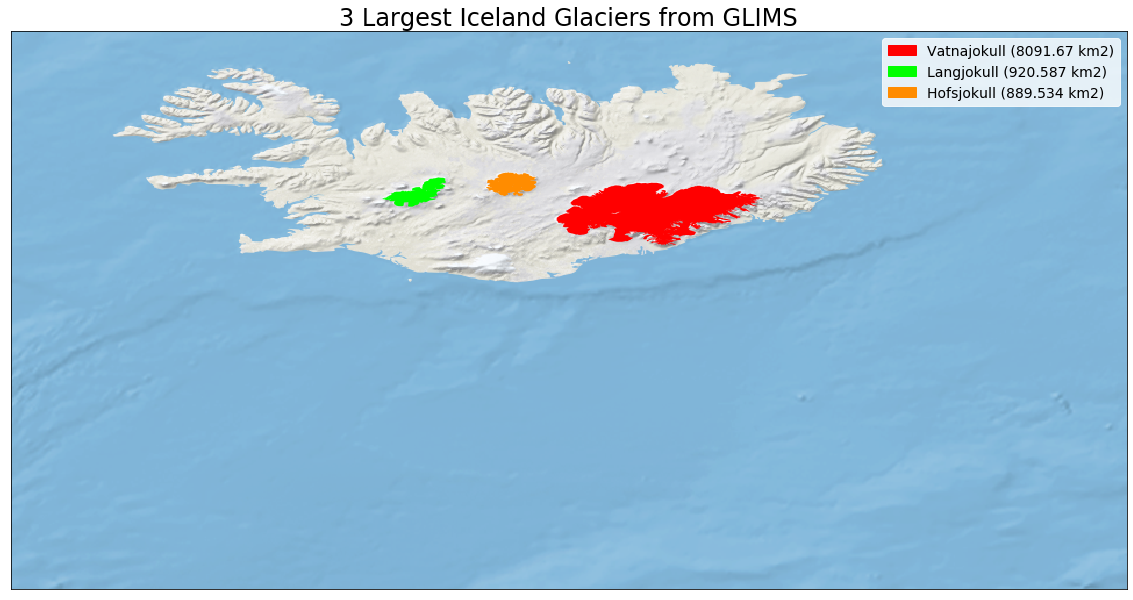

In [13]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['db_area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Plot RGI Glaciers

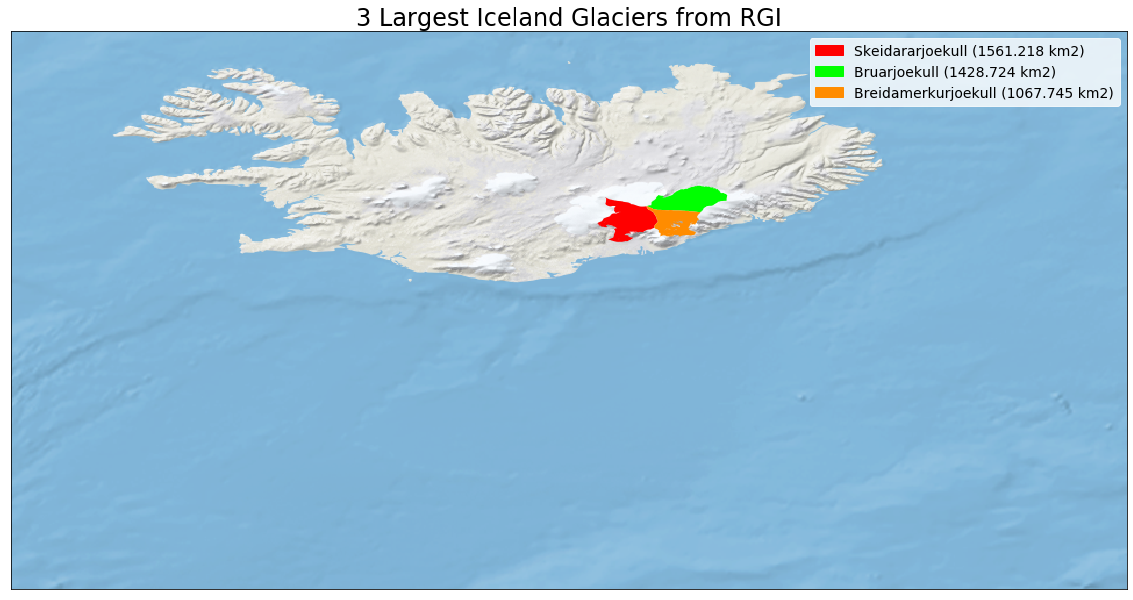

In [14]:
# Plot 3 largest glaciers on natural earth from RGI
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][0] + ' (' + str(rgi_glaciers_df['Area'][0]) + ' km2)',
                 rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate. Once the differences have been investigated and corrected in the code below this code block, set handled to 1 in the "Set Up Region Info" section at the top of the notebook, so that it passes this test.

In [15]:
if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
    print("They match!")
else:
    if handled != 1:
        # If this hasn't been handled, stop execution
        class StopExecution(Exception):
            def _render_traceback_(self):
                pass

        print("They do NOT Match! Stopping notebook.")
        raise StopExecution
    else:
        # If this has been handled, continue execution
        print("They do not match but this has been handled in the code below this section, so continue.")

They do not match but this has been handled in the code below this section, so continue.


## Create Final Glacier Shapefiles
This section creates and formats the final glacier dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

NOTE: The GLIMS database contains outlines of the ice caps only and not the individual outlet glaciers. The RGI database does contain the glacier outlines, so will use RGI for the glaciers.

### Create final glacier dataframe

In [16]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use RGI dataframe for this)
final_glacier_data_df = rgi_glaciers_df.drop(['EndDate', 'CenLon', 'CenLat', 
                                              'O2Region', 'Zmin', 'Zmax', 'Zmed', 'Slope',
                                              'Aspect', 'Lmax', 'Status', 'Connect', 'Form',
                                              'TermType', 'Surging', 'Linkages'], axis=1)

# Add region_name column
final_glacier_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_glacier_data_df['primeclass'] = primeclass

# Add area_src column that gets filled lower down
final_glacier_data_df['area_src'] = 'R'

# Reorder the columns of the dataframe
final_glacier_data_df = final_glacier_data_df[['O1Region', 'reg_name', 'Name', 'GLIMSId', 'RGIId',
                                               'primeclass', 'Area', 'area_src', 'BgnDate', 'geometry']]

# Rename some columns
final_glacier_data_df.rename(columns={'O1Region': 'region_no', 'Name': 'glac_name', 
                                      'GLIMSId': 'glims_id', 'RGIId': 'rgi_id','Area': 'area_km2', 
                                      'BgnDate': 'date'}, inplace=True)

# Drop last 2 rows because they are the fourth and fifthe largest glaciers and we aren't interested in them
final_glacier_data_df.drop([3, 4], inplace = True)

# Format date and update glacier name spelling
glacier_name = ['Skeidararjökull', 'Bruarjökull', 'Breidamerkurjökull']
for i, row in final_glacier_data_df.iterrows():
    date = row['date']
    year = date[0:4]
    month = date[4:6]
    day = date[6:8]
    # print(year + month + day)
    new_date = year + "-" + month + "-" + day
    #print(new_date)
    final_glacier_data_df.at[i,'date'] = new_date
    final_glacier_data_df.at[i,'glac_name'] = glacier_name[i]

In [17]:
final_glacier_data_df

,region_no,reg_name,glac_name,glims_id,rgi_id,primeclass,area_km2,area_src,date,geometry
0,6,Iceland,Skeidararjökull,G342858E64298N,RGI60-06.00475,4,1561.218,R,2000-99-99,POLYGON ((-16.88670427699998 64.49112664700004...
1,6,Iceland,Bruarjökull,G343733E64587N,RGI60-06.00377,4,1428.724,R,2000-99-99,POLYGON ((-16.14149351299994 64.78313950300003...
2,6,Iceland,Breidamerkurjökull,G343523E64267N,RGI60-06.00483,4,1067.745,R,2000-99-99,POLYGON ((-16.87625468499994 64.49406953800008...


### Plot final glacier dataframe to check accuracy

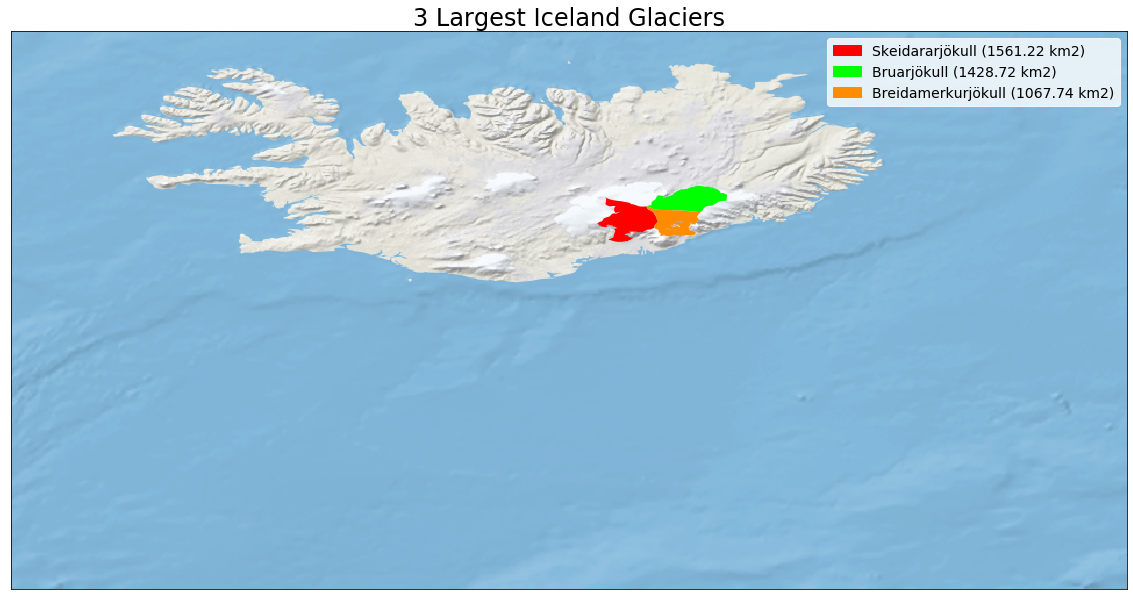

In [18]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_glacier_data_df['glac_name'][0] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][0], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][1] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][1], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][2] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_glacier_data_df.iloc[0:1].plot(ax=ax, color='red')
final_glacier_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_glacier_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Create largest glacier shapefile from the final glacier dataframe

In [19]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
glacier_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(glacier_zipfile_fn) == False:
    # Create the shapefile
    final_glacier_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_glacier_data_df.to_file(driver='ESRI Shapefile', filename=final_glacier_data_fn)
    
    # Zip up the shapefile
    glacier_zipfile_fn = ws.zipshp(final_glacier_data_fn, Delete=True)
    print("Creating zipfile: " + glacier_zipfile_fn)
else:
    print(glacier_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-6-largest-glaciers.zip


# * * * * * * * * Ice Cap Analysis * * * * * * * *

NOTE: The GLIMS database contians the ice cap outlines for Region 6, so don't need to do the extra "explode" step. Can just take the information and outlines straight out of GLIMS.

The following code that examines the "exploded" data is left here for reference.

In [ ]:
# Open this regions ice caps from the exploded version
ice_caps_ex_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + \
                  region_number + "_epsg" + ic_epsg + ".shp"
ice_caps_ex_df = gpd.read_file(ice_caps_ex_fn)

In [ ]:
ice_caps_ex_df

In [ ]:
# Plot this regions ice caps in one frame
# Set up legend, note these ice cap names are not correct
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
legend_labels = ['Penny Ice Cap (1771)', 'Barnes Ice Cap (3382)', 'Bylot Island Ice Cap (3251)', 
                 'Cape Macculloch Ice Cap? (3344)', 'Unknown (1795)', 'Unknown (1915)', 'Unknown (3487)', 
                 'Unknown (3346)', 'Unknown (1904)', 'Unknown (3343)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

In [ ]:
# Stop notebook and examine ice caps and icefields. 
# Comment this out when not needed.
#class StopExecution(Exception):
#    def _render_traceback_(self):
#        pass

#print("Stopping notebook to examine glacier complexes.")
#raise StopExecution

## Create Final Ice Catchment Data Frame
This ice catchment data frame will then be saved to a shapefile.

NOTE: The original polygons from the GLIMS database are used instead of the exploded data (ice_caps_ex_df).

In [12]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 'src_date',
                                                  'min_elev', 'mean_elev', 'max_elev', 'glac_name'], axis=1)

# Drop last 2 rows because only interested in the top 3 ice caps
final_catchment_data_df.drop([3, 4], inplace = True)

# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_catchment_data_df['primeclass'] = [3, 3, 3]

# Add catchment names
final_catchment_data_df['ic_name'] = ['Vatnajökull Ice Cap', 'Langjökull Ice Cap', 'Hofsjökull Ice Cap']

In [13]:
final_catchment_data_df

,region_no,glac_id,db_area,primeclass,geometry,reg_name,ic_name
0,6,G343222E64409N,8091.670,3,"(POLYGON Z ((-15.37719 64.66761 0, -15.3766 64...",Iceland,Vatnajökull Ice Cap
1,6,G339764E64629N,920.587,3,"POLYGON Z ((-20.67335 64.596 0, -20.67194 64.5...",Iceland,Langjökull Ice Cap
2,6,G341164E64838N,889.534,3,"POLYGON Z ((-19.18387 64.75879999999999 0, -19...",Iceland,Hofsjökull Ice Cap


In [14]:
# Add the dates to the dataframe
vatna_glaciers_min_date = glims_glaciers_df.iloc[0]['src_date'][0:10]
vatna_glaciers_max_date = glims_glaciers_df.iloc[0]['src_date'][0:10]
lang_glaciers_min_date = glims_glaciers_df.iloc[1]['src_date'][0:10]
lang_glaciers_max_date = glims_glaciers_df.iloc[1]['src_date'][0:10]
hofs_glaciers_min_date = glims_glaciers_df.iloc[2]['src_date'][0:10]
hofs_glaciers_max_date = glims_glaciers_df.iloc[2]['src_date'][0:10]
final_catchment_data_df['min_date'] = [vatna_glaciers_min_date, lang_glaciers_min_date, hofs_glaciers_min_date]
final_catchment_data_df['max_date'] = [vatna_glaciers_max_date, lang_glaciers_max_date, hofs_glaciers_max_date]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'db_area', 
                                                   'min_date', 'max_date', 'glac_id', 'geometry']]

# Rename some columns
final_catchment_data_df.rename(columns={'db_area': 'area_km2', 'glac_id': 'glims_ids'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [15]:
final_catchment_data_df

,region_no,reg_name,ic_name,primeclass,area_km2,min_date,max_date,glims_ids,geometry
0,6,Iceland,Vatnajökull Ice Cap,3,8091.670,1999-01-01,1999-01-01,G343222E64409N,"(POLYGON Z ((-15.37719 64.66761 0, -15.3766 64..."
1,6,Iceland,Langjökull Ice Cap,3,920.587,2000-08-20,2000-08-20,G339764E64629N,"POLYGON Z ((-20.67335 64.596 0, -20.67194 64.5..."
2,6,Iceland,Hofsjökull Ice Cap,3,889.534,1999-08-01,1999-08-01,G341164E64838N,"POLYGON Z ((-19.18387 64.75879999999999 0, -19..."


### Plot the final catchment dataframe to verify it looks correct

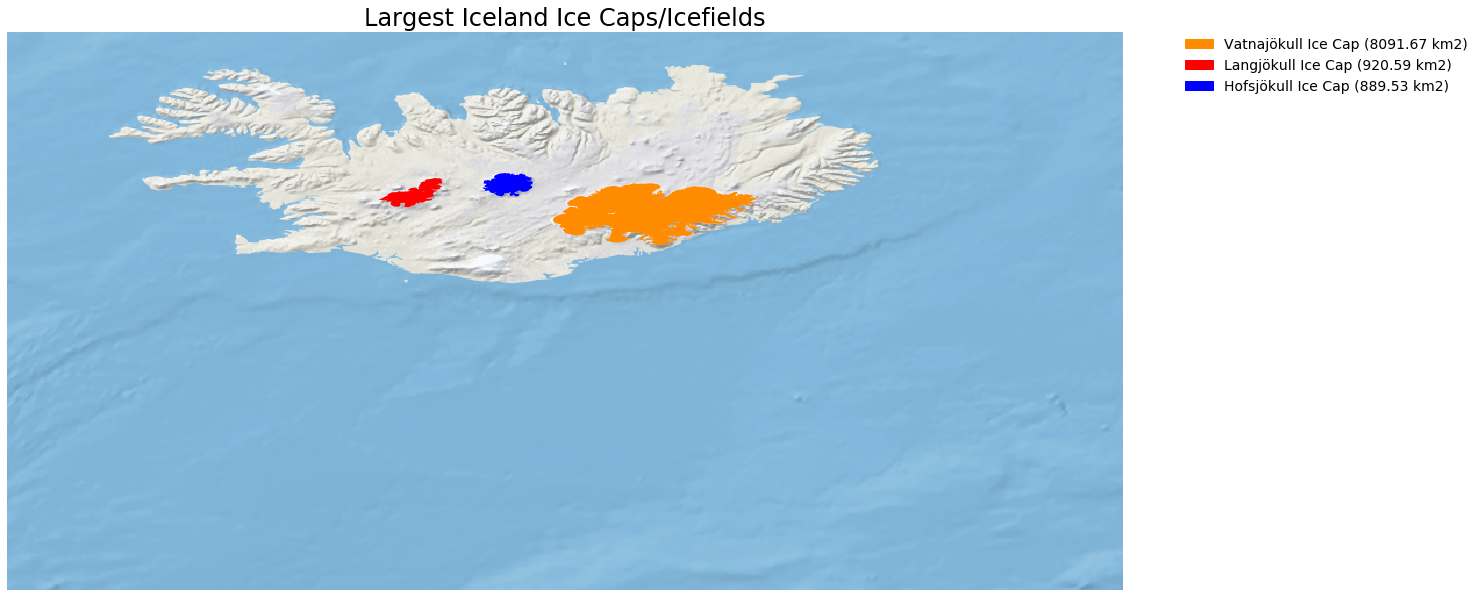

In [16]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="darkorange")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="red")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="blue")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Save final catchment dataframe to a shapefile

In [17]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-6-largest-complexes.zip
